{0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: '', 10: '', 11: '', 12: '', 13: '', 14: '', 15: '', 16: '', 17: '', 18: '', 19: '', 20: '', 21: '', 22: '', 23: '', 24: '', 25: '', 26: '', 27: '', 28: '', 29: '', 30: '', 31: '', 32: '', 33: '', 34: '', 35: '', 36: '', 37: '', 38: '', 39: '', 40: '', 41: '', 42: '', 43: '', 44: '', 45: '', 46: '', 47: '', 48: '', 49: '', 50: '', 51: '', 52: '', 53: '', 54: '', 55: '', 56: '', 57: '', 58: '', 59: '', 60: '', 61: '', 62: '', 63: '', 64: '', 65: '', 66: '', 67: '', 68: '', 69: '', 70: '', 71: '', 72: '', 73: '', 74: '', 75: '', 76: '', 77: '', 78: '', 79: '', 80: '', 81: '', 82: '', 83: '', 84: '', 85: '', 86: '', 87: '', 88: '', 89: '', 90: '', 91: '', 92: '', 93: '', 94: '', 95: '', 96: '', 97: '', 98: '', 99: '', 100: '', 101: '', 102: '', 103: '', 104: '', 105: '', 106: '', 107: '', 108: '', 109: '', 110: '', 111: '', 112: '', 113: '', 114: '', 115: '', 116: '', 117: '', 118: '', 119: '', 120: '', 121: '', 122: '', 12

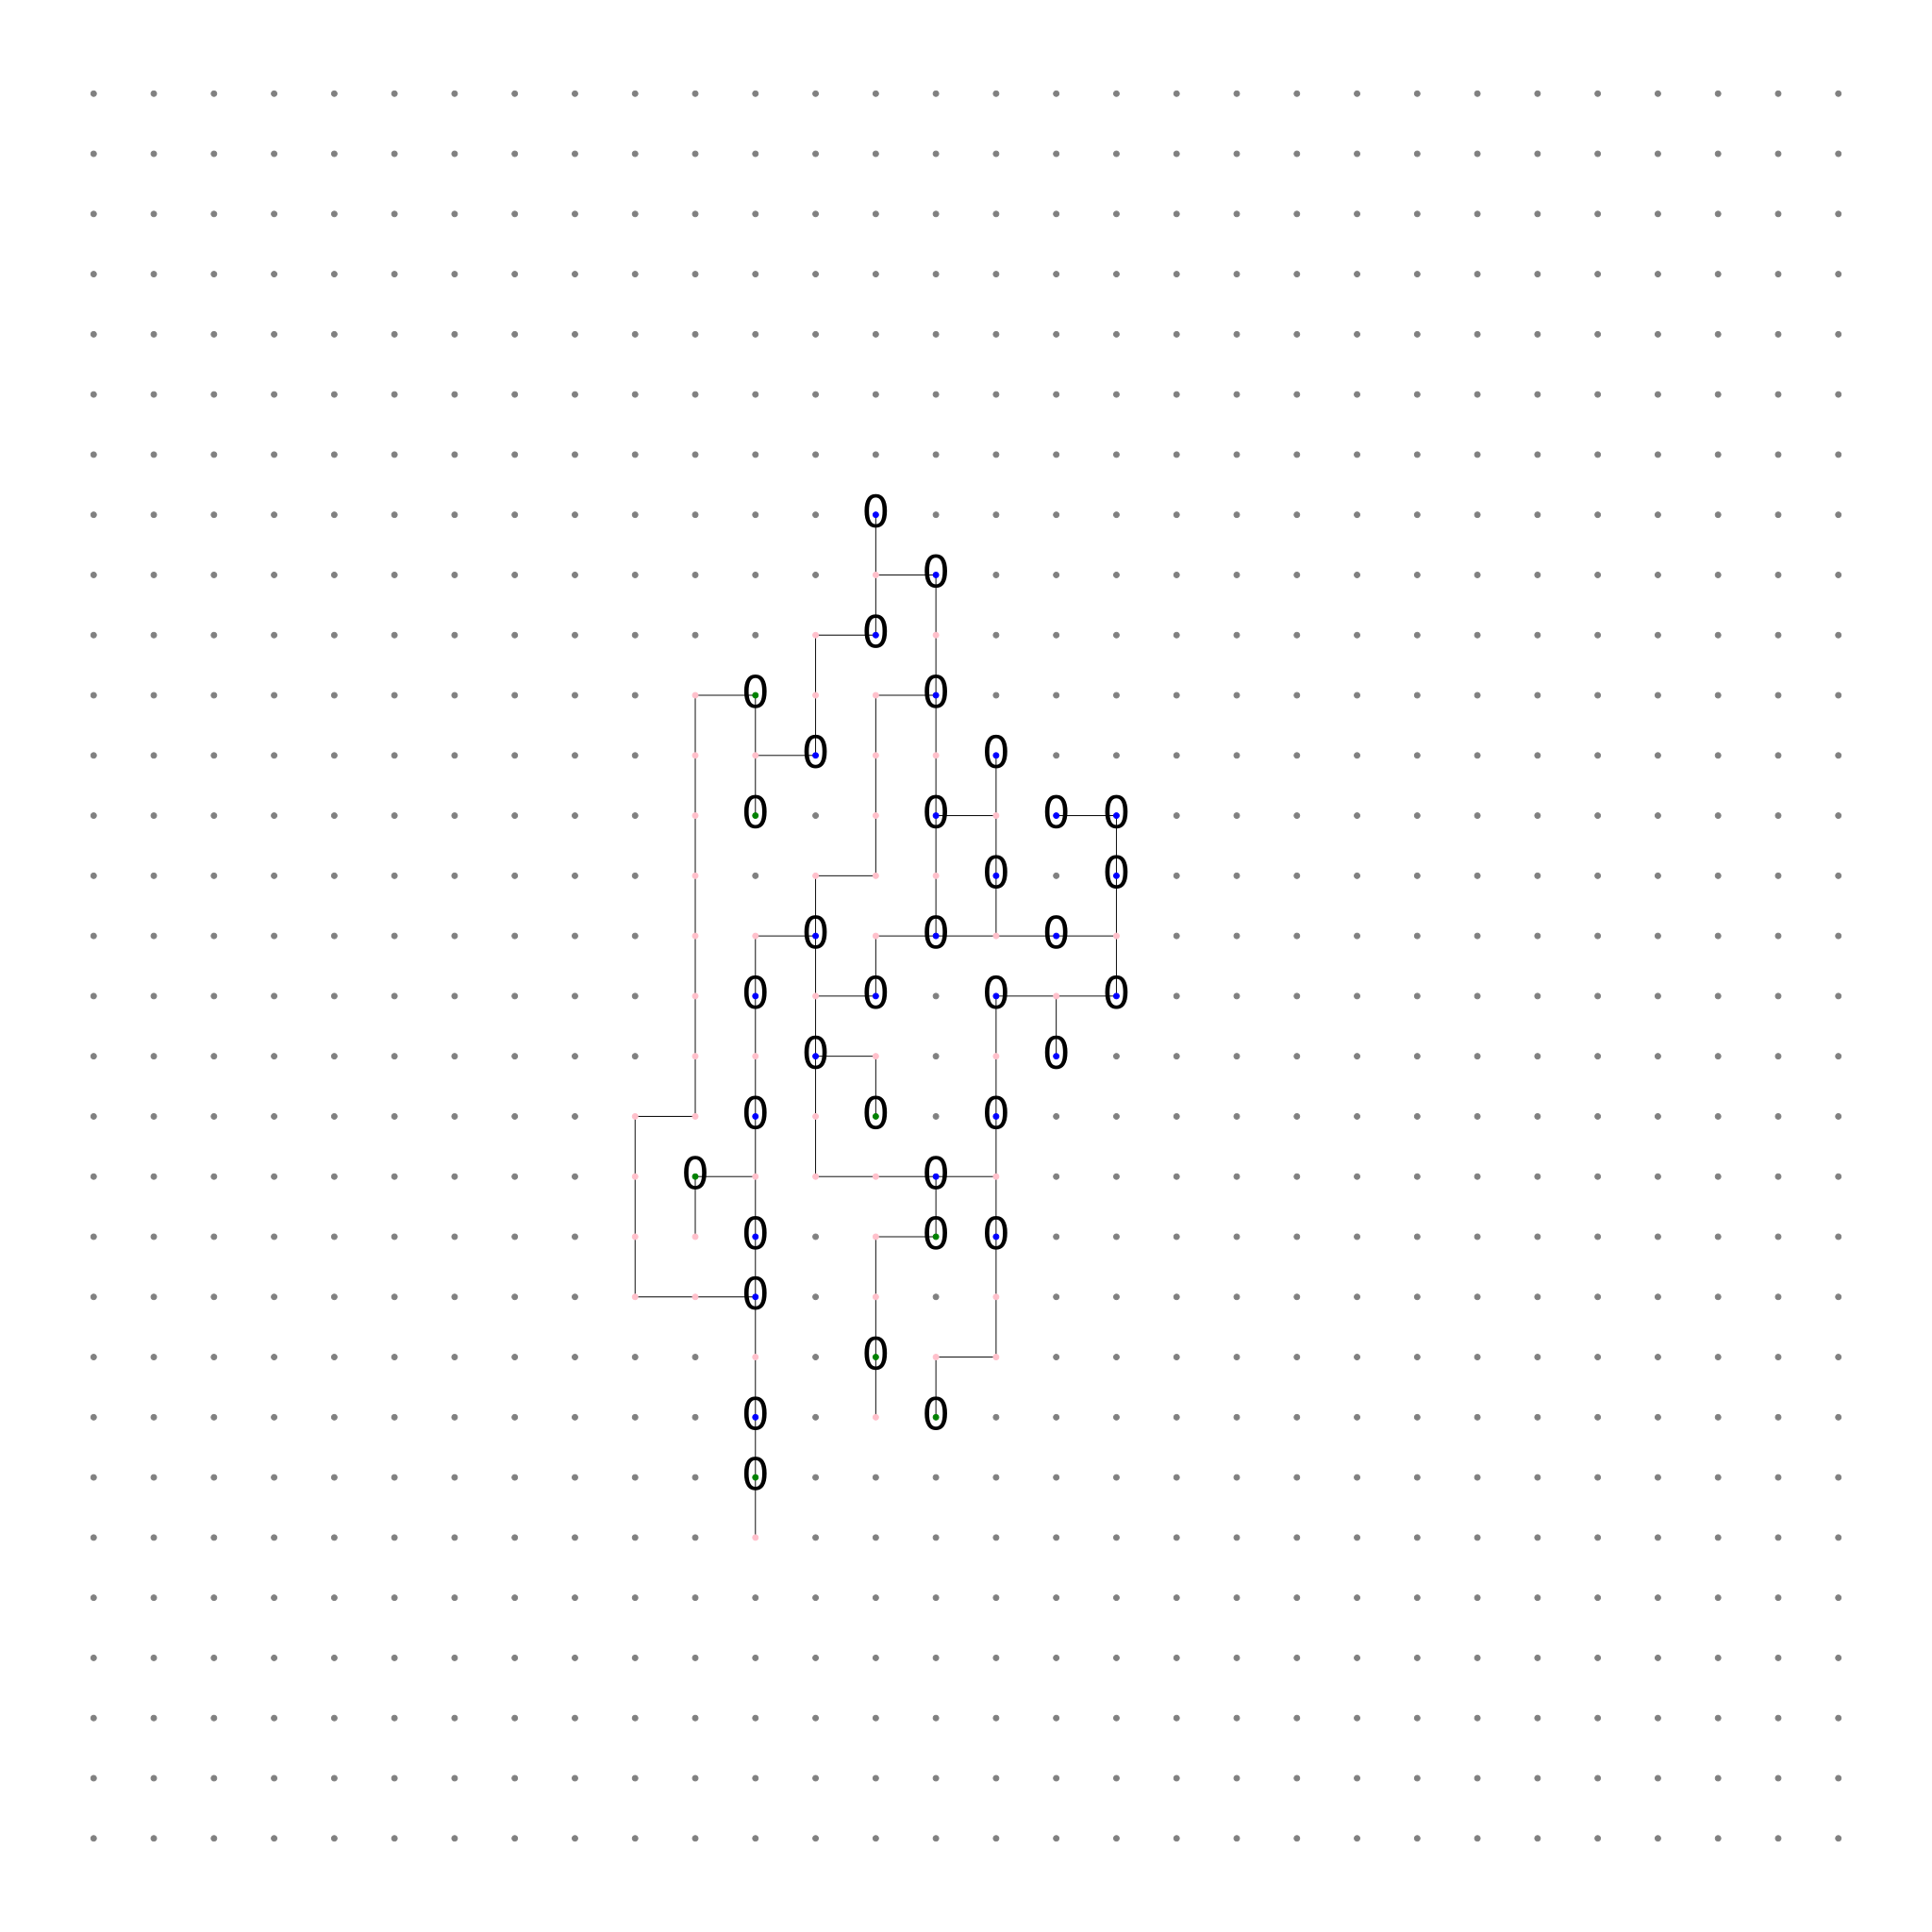

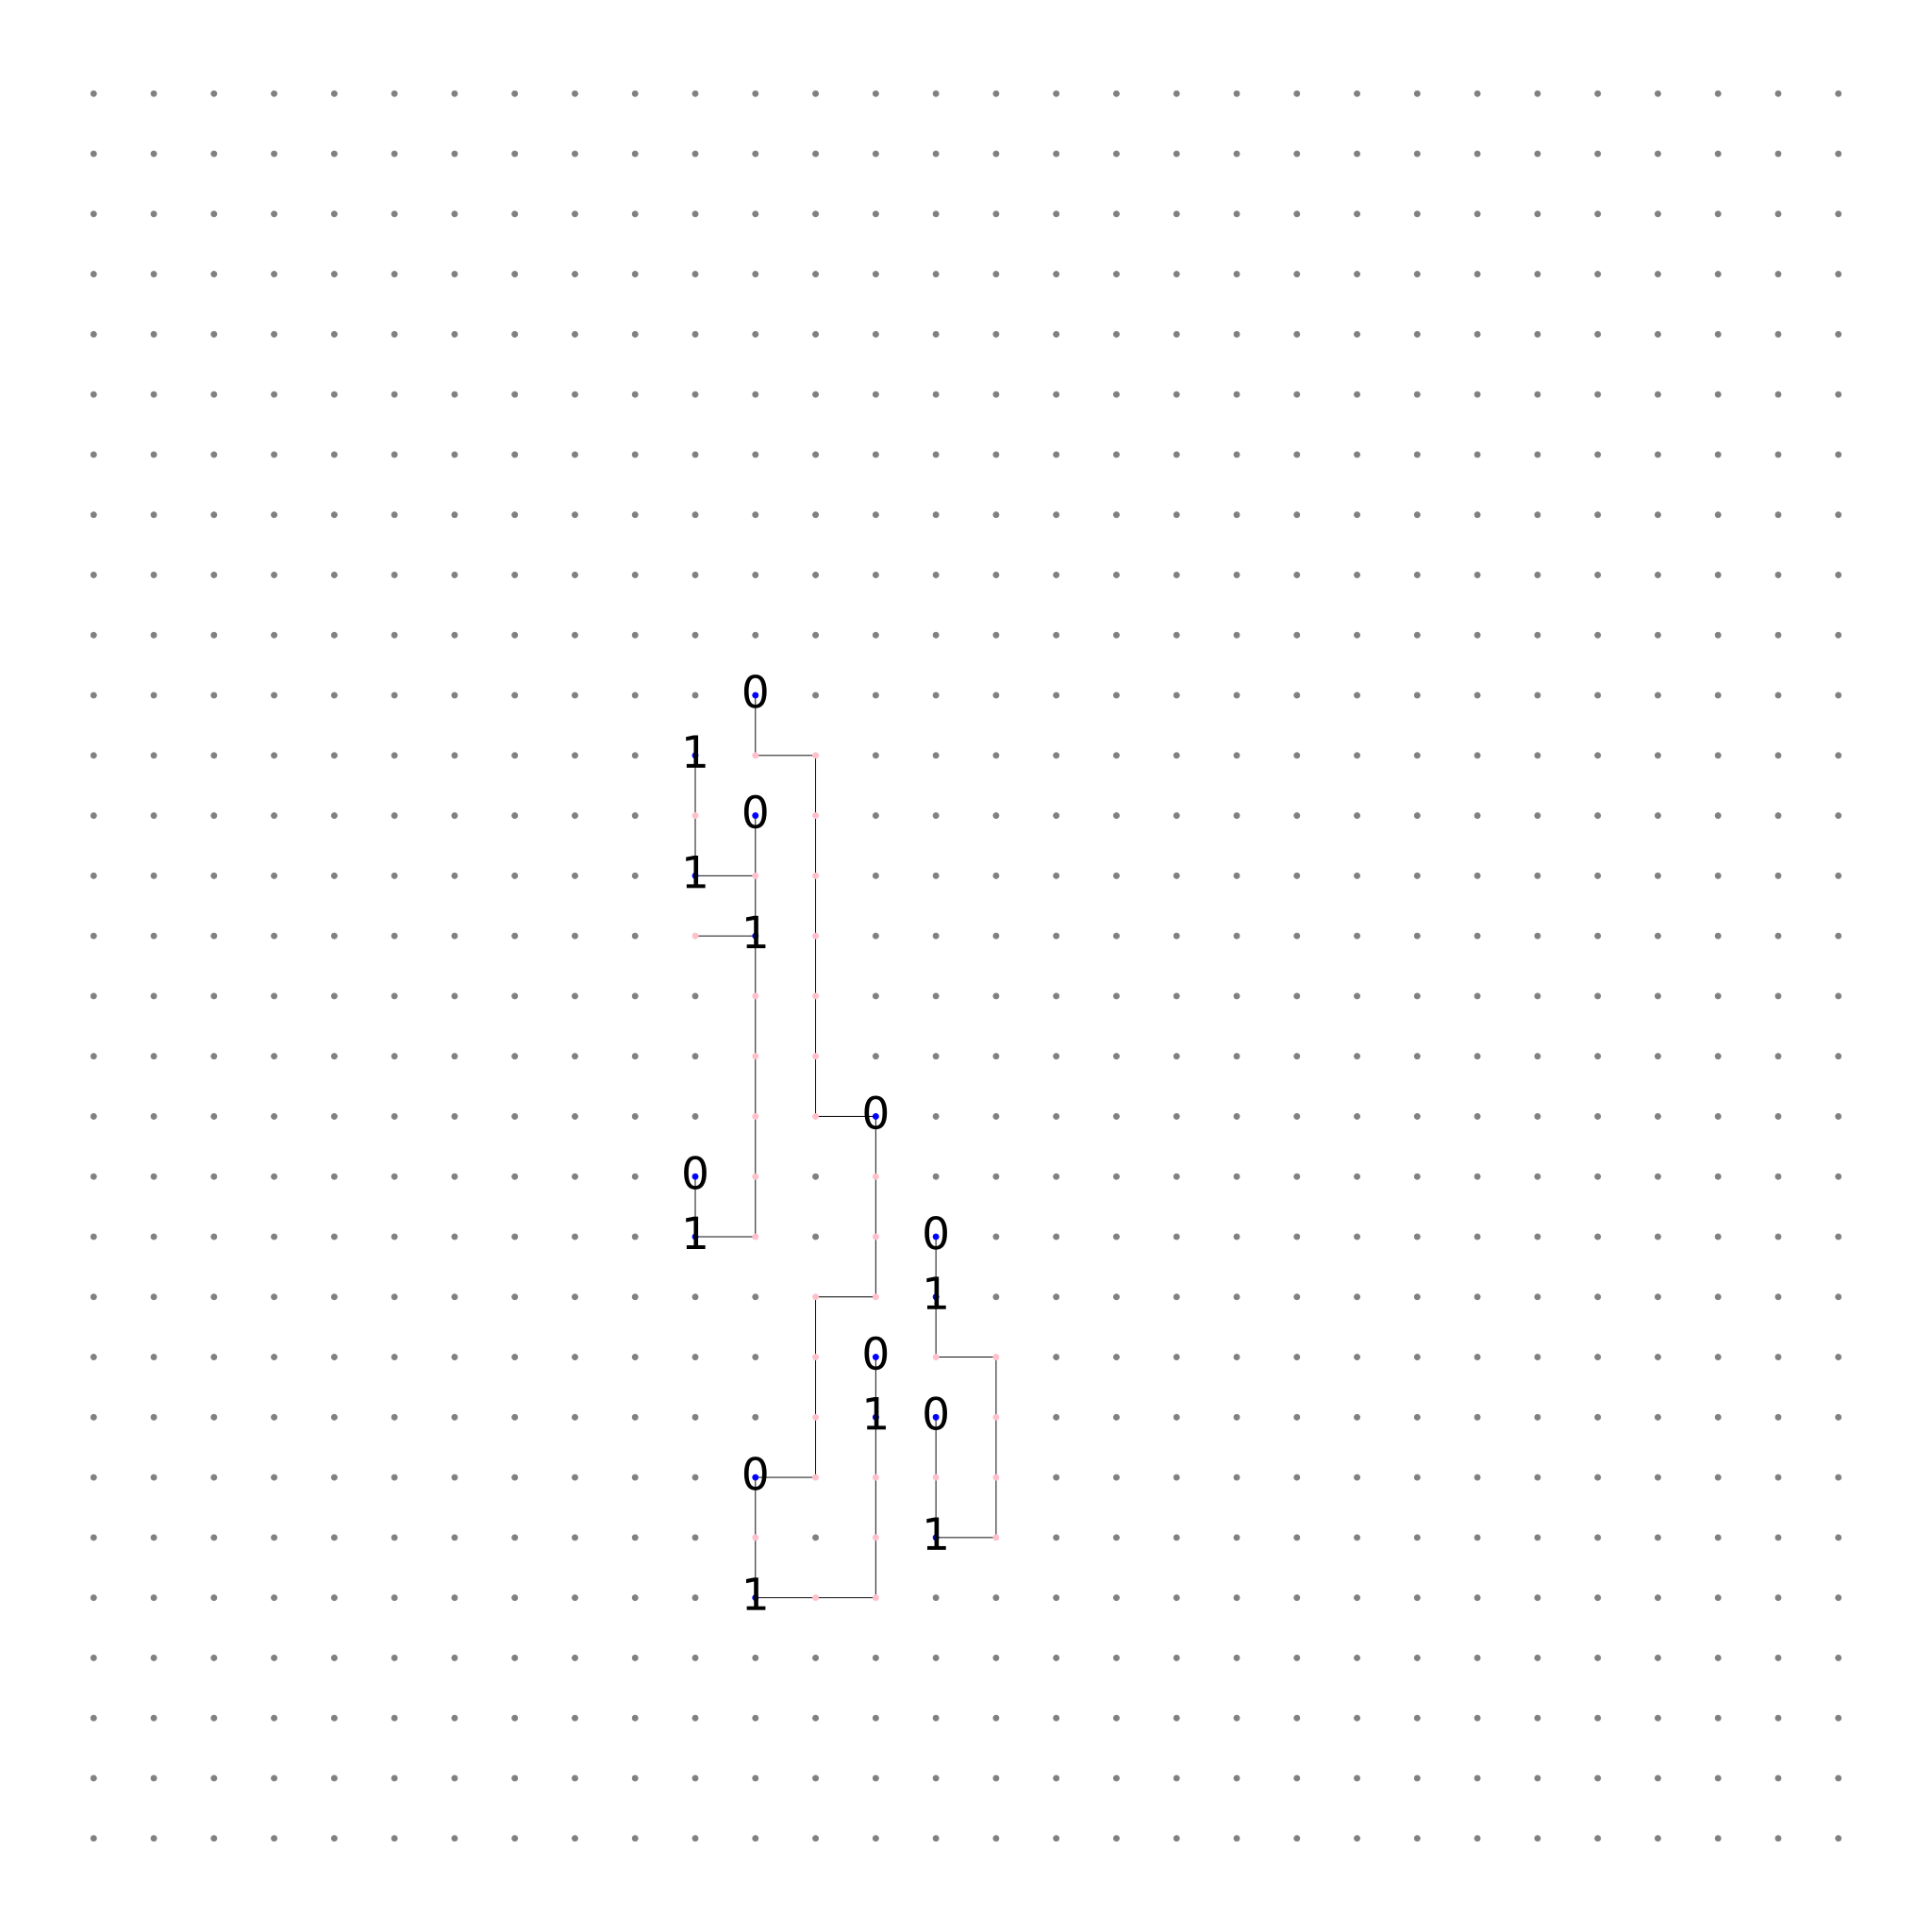

In [3]:
from Partition import *
from Fusion import *
from Graph_State import *
from Compact_Graph import *

NQubit = 4
Depth = 20
MaxDegree = 3

def to_undirected(gs):
    undirected_graph = nx.Graph()
    for nnode in gs.nodes():
        undirected_graph.add_node(nnode)
        undirected_graph.nodes[nnode]['layer'] = gs.nodes[nnode]['layer']
    for edge in gs.edges():
        if edge not in undirected_graph.edges():
            undirected_graph.add_edge(edge[0], edge[1])
    return undirected_graph

def main():
    gs, input_nodes, colors = generate_graph_state(NQubit, Depth)
    gs = partition(gs, input_nodes)
    undirected_graph = to_undirected(gs)
    fgraph, added_nodes = fusion_graph(undirected_graph, MaxDegree)
    compact_graph(fgraph)
    # labels = nx.get_node_attributes(gs, 'layer')
    # node_pos = nx.get_node_attributes(gs, 'pos')
    # nx.draw(gs, pos = node_pos, node_color = colors, node_size = 10, labels = labels,  font_size=5)
    # print(labels)
    return

if __name__ == '__main__':
    main()